# Install dependencies

In [1]:
!pip -q install pandas numpy scikit-learn matplotlib xgboost shap

# Connect to Drive and set Directory Paths

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
from pathlib import Path

PROJECT = "churn_prediction_business_pipeline"
BASE = Path("/content/drive/MyDrive") / PROJECT
DATA_DIR = BASE / "data"
PLOTS_DIR = BASE / "plots"
MODELS_DIR = BASE / "models"

for d in [DATA_DIR, PLOTS_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("BASE:", BASE)

BASE: /content/drive/MyDrive/churn_prediction_business_pipeline


# Load-clean-split Dataset

In [4]:
# The dataset is available on the github link below
# https://github.com/IBM/telco-customer-churn-on-icp4d.git
# Download the csv file and add it to drive

import pandas as pd
from pathlib import Path

DATA_PATH = Path("/content/drive/MyDrive/churn_prediction_business_pipeline/data/Telco-Customer-Churn.csv")

df = pd.read_csv(DATA_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
# Quick confirmation
df.shape
df.columns
df["Churn"].value_counts()

,count
Churn,
No,5174
Yes,1869


In [5]:
# target: "Churn" -> 1/0
df["Churn"] = (df["Churn"].astype(str).str.strip().str.lower() == "yes").astype(int)

# TotalCharges has blanks; coerce to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop ID column
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# Drop rows with missing TotalCharges
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

df.shape, df["Churn"].mean()

((7032, 20), np.float64(0.26578498293515357))

In [6]:
# Train/Validation/Test Split
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape)
print("Churn rate:", y_train.mean(), y_val.mean(), y_test.mean())

(4922, 19) (1055, 19) (1055, 19)
Churn rate: 0.2657456318569687 0.2663507109004739 0.26540284360189575


In [7]:
# Preprocess: one-hot encode categoricals + scale numerics

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

num_cols, cat_cols[:5], len(cat_cols)

(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines'],
 15)

# Models

In [10]:
# Model 1 - Logistic Regression Baseline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

lr_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

lr_model.fit(X_train, y_train)

val_proba_lr = lr_model.predict_proba(X_val)[:, 1]
print("LR Val ROC-AUC:", roc_auc_score(y_val, val_proba_lr))
print("LR Val PR-AUC :", average_precision_score(y_val, val_proba_lr))

LR Val ROC-AUC: 0.8531292817273121
LR Val PR-AUC : 0.6536612309798182


In [12]:
# Model 2 - XGBoost

from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", XGBClassifier(
        n_estimators=500,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)

val_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]
print("XGB Val ROC-AUC:", roc_auc_score(y_val, val_proba_xgb))
print("XGB Val PR-AUC :", average_precision_score(y_val, val_proba_xgb))

XGB Val ROC-AUC: 0.8432577450412426
XGB Val PR-AUC : 0.6776818476179516


# Plot ROC and PR curves

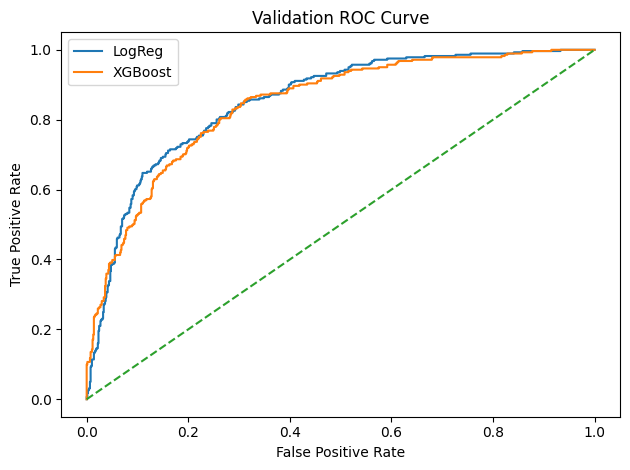

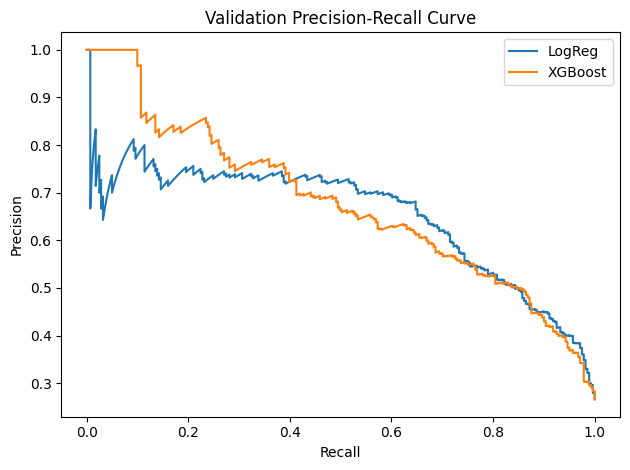

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

def save_plot(path):
    plt.tight_layout()
    plt.savefig(path, dpi=200)
    plt.show()

# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_val, val_proba_lr)
fpr_x, tpr_x, _ = roc_curve(y_val, val_proba_xgb)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_x, tpr_x, label="XGBoost")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Validation ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
save_plot(PLOTS_DIR / "val_roc.png")

# PR
p_lr, r_lr, _ = precision_recall_curve(y_val, val_proba_lr)
p_x, r_x, _ = precision_recall_curve(y_val, val_proba_xgb)

plt.figure()
plt.plot(r_lr, p_lr, label="LogReg")
plt.plot(r_x, p_x, label="XGBoost")
plt.title("Validation Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
save_plot(PLOTS_DIR / "val_pr.png")

# Threshold Optimization (Business style)

In [17]:
import numpy as np
from pathlib import Path

COST_CONTACT = 1.0
VALUE_SAVE = 20.0

def expected_value(y_true, y_proba, threshold):
    pred = (y_proba >= threshold).astype(int)
    # contact = pred==1
    contacted = pred.sum()
    # true positives = churners correctly contacted
    tp = ((pred == 1) & (y_true == 1)).sum()
    # value - cost
    return tp * VALUE_SAVE - contacted * COST_CONTACT

thresholds = np.linspace(0.05, 0.95, 91)
values = [expected_value(y_val.values, val_proba_xgb, t) for t in thresholds]
best_idx = int(np.argmax(values))
best_t = float(thresholds[best_idx])

best_t, values[best_idx]


MODELS_DIR = Path("/content/drive/MyDrive/churn_prediction_business_pipeline/models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

threshold_path = MODELS_DIR / "best_threshold.txt"

with open(threshold_path, "w") as f:
    f.write(str(best_t))

print("Saved best threshold to:", threshold_path)


Saved best threshold to: /content/drive/MyDrive/churn_prediction_business_pipeline/models/best_threshold.txt


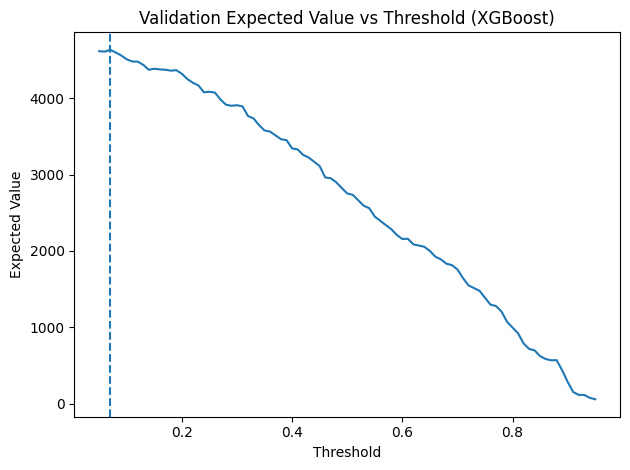

Best threshold: 0.07


In [18]:
# Plot

plt.figure()
plt.plot(thresholds, values)
plt.title("Validation Expected Value vs Threshold (XGBoost)")
plt.xlabel("Threshold")
plt.ylabel("Expected Value")
plt.axvline(best_t, linestyle="--")
save_plot(PLOTS_DIR / "val_threshold_value.png")
print("Best threshold:", best_t)


# Final Test evaluation (Using best threshold)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

test_proba = xgb_model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= best_t).astype(int)

print("TEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print("TEST PR-AUC :", average_precision_score(y_test, test_proba))

print("\nConfusion matrix:\n", confusion_matrix(y_test, test_pred))
print("\nReport:\n", classification_report(y_test, test_pred, target_names=["no-churn","churn"]))

TEST ROC-AUC: 0.8147096774193548
TEST PR-AUC : 0.5903343652823299

Confusion matrix:
 [[363 412]
 [ 19 261]]

Report:
               precision    recall  f1-score   support

    no-churn       0.95      0.47      0.63       775
       churn       0.39      0.93      0.55       280

    accuracy                           0.59      1055
   macro avg       0.67      0.70      0.59      1055
weighted avg       0.80      0.59      0.61      1055



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

test_proba = lr_model.predict_proba(X_test)[:, 1]
test_pred = (test_proba >= best_t).astype(int)

print("TEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print("TEST PR-AUC :", average_precision_score(y_test, test_proba))

print("\nConfusion matrix:\n", confusion_matrix(y_test, test_pred))
print("\nReport:\n", classification_report(y_test, test_pred, target_names=["no-churn","churn"]))

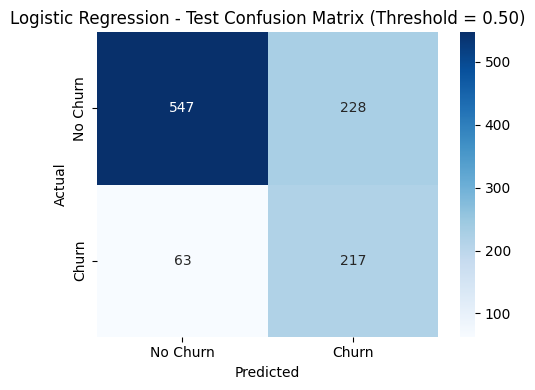

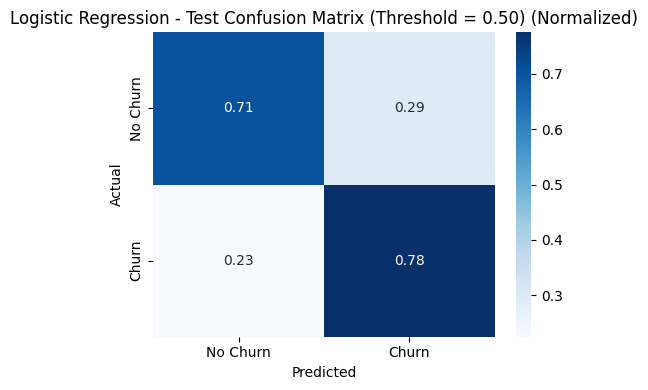

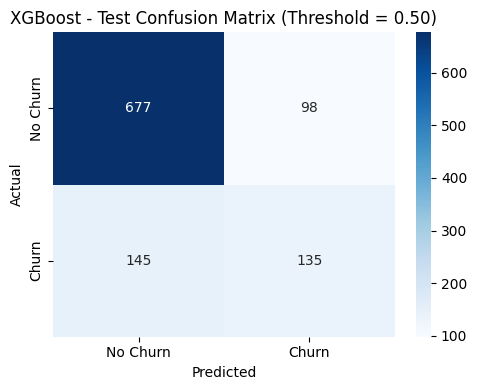

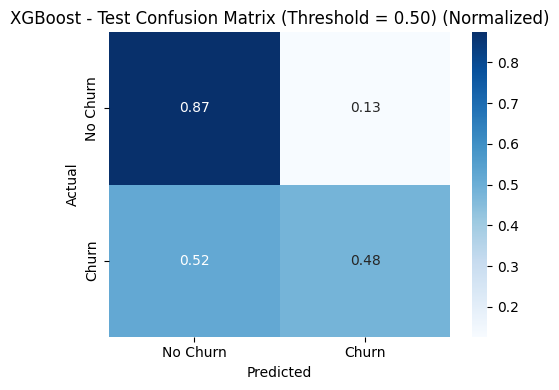

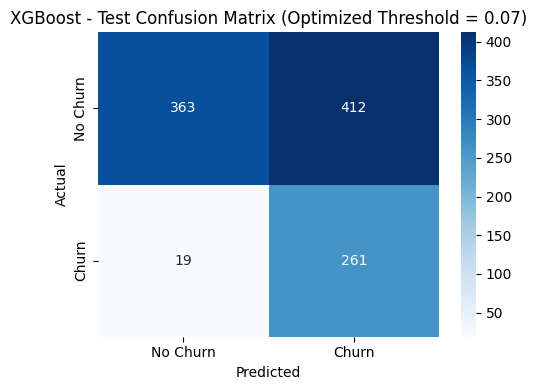

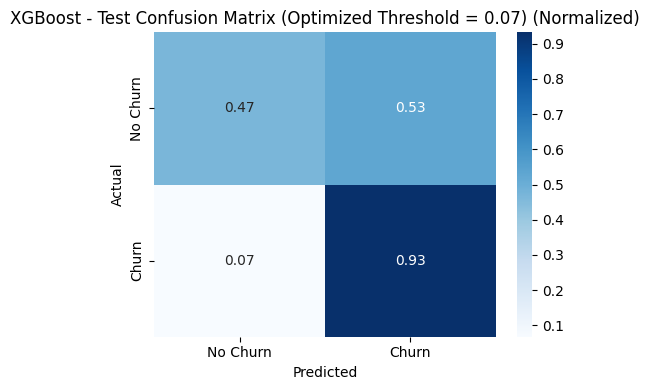

Saved confusion matrices to: /content/drive/MyDrive/churn_prediction_business_pipeline/plots


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_and_save_cm(y_true, y_pred, title, out_path, normalize=False):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm_plot = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
        suffix = " (Normalized)"
    else:
        cm_plot = cm
        fmt = "d"
        suffix = ""

    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm_plot,
        annot=True,
        fmt=fmt,
        cmap="Blues",
        xticklabels=["No Churn", "Churn"],
        yticklabels=["No Churn", "Churn"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title + suffix)
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.show()

# Logistic Regression @ 0.5
lr_test_proba = lr_model.predict_proba(X_test)[:, 1]
lr_test_pred_05 = (lr_test_proba >= 0.5).astype(int)

plot_and_save_cm(
    y_test, lr_test_pred_05,
    title="Logistic Regression - Test Confusion Matrix (Threshold = 0.50)",
    out_path=PLOTS_DIR / "cm_lr_thresh_0p50.png",
    normalize=False
)
plot_and_save_cm(
    y_test, lr_test_pred_05,
    title="Logistic Regression - Test Confusion Matrix (Threshold = 0.50)",
    out_path=PLOTS_DIR / "cm_lr_thresh_0p50_normalized.png",
    normalize=True
)

# XGBoost @ 0.5
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_test_pred_05 = (xgb_test_proba >= 0.5).astype(int)

plot_and_save_cm(
    y_test, xgb_test_pred_05,
    title="XGBoost - Test Confusion Matrix (Threshold = 0.50)",
    out_path=PLOTS_DIR / "cm_xgb_thresh_0p50.png",
    normalize=False
)
plot_and_save_cm(
    y_test, xgb_test_pred_05,
    title="XGBoost - Test Confusion Matrix (Threshold = 0.50)",
    out_path=PLOTS_DIR / "cm_xgb_thresh_0p50_normalized.png",
    normalize=True
)

# XGBoost @ optimized threshold (business-aware)
xgb_test_pred_opt = (xgb_test_proba >= best_t).astype(int)

plot_and_save_cm(
    y_test, xgb_test_pred_opt,
    title=f"XGBoost - Test Confusion Matrix (Optimized Threshold = {best_t:.2f})",
    out_path=PLOTS_DIR / "cm_xgb_thresh_opt.png",
    normalize=False
)
plot_and_save_cm(
    y_test, xgb_test_pred_opt,
    title=f"XGBoost - Test Confusion Matrix (Optimized Threshold = {best_t:.2f})",
    out_path=PLOTS_DIR / "cm_xgb_thresh_opt_normalized.png",
    normalize=True
)

print("Saved confusion matrices to:", PLOTS_DIR)


# SHAP explainability (XGBoost)

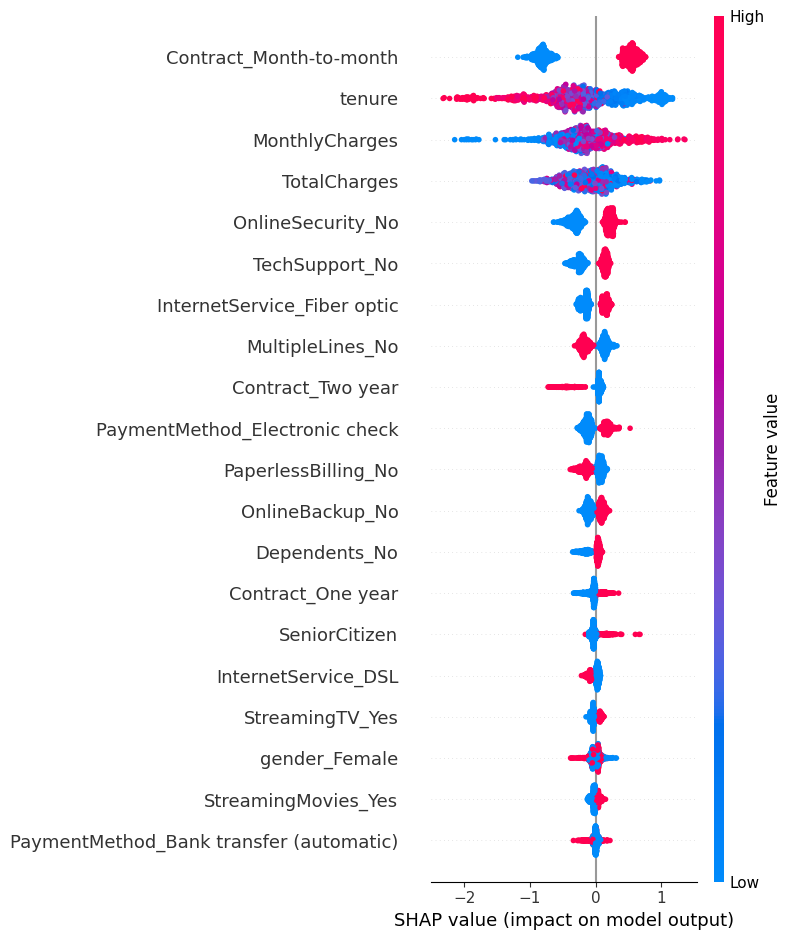

In [20]:
import shap

# Processed feature matrix + feature names from the pipeline
ohe = xgb_model.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = num_cols + cat_feature_names

X_val_processed = xgb_model.named_steps["preprocess"].transform(X_val)

booster = xgb_model.named_steps["clf"]
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_val_processed)

plt.figure()
shap.summary_plot(shap_values, X_val_processed, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig(PLOTS_DIR / "shap_summary.png", dpi=200)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix (Threshold = {:.2f})".format(best_t))
plt.tight_layout()

plt.savefig(PLOTS_DIR / "test_confusion_matrix.png", dpi=200)
plt.show()


# Save model

In [21]:
import joblib
# Save XGBoost
model_path = MODELS_DIR / "xgb_churn_pipeline.joblib"
joblib.dump(xgb_model, model_path)
print("Saved model to:", model_path)

Saved model to: /content/drive/MyDrive/churn_prediction_business_pipeline/models/xgb_churn_pipeline.joblib


In [22]:
# Save Logistic Regression
lr_path = MODELS_DIR / "lr_churn_pipeline.joblib"
joblib.dump(lr_model, lr_path)
print("Saved Logistic Regression model to:", lr_path)

Saved Logistic Regression model to: /content/drive/MyDrive/churn_prediction_business_pipeline/models/lr_churn_pipeline.joblib


# API main

In [21]:
%%writefile main.py
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd
from pathlib import Path

# ============================
MODELS_DIR = Path("/content/drive/MyDrive/churn_prediction_business_pipeline/models")
LR_PATH = MODELS_DIR / "lr_churn_pipeline.joblib"
XGB_PATH = MODELS_DIR / "xgb_churn_pipeline.joblib"
THRESH_PATH = MODELS_DIR / "best_threshold.txt"
# ============================

app = FastAPI(title="Churn Prediction API")

# Load models (full sklearn Pipelines: preprocess + model
lr_model = joblib.load(LR_PATH))
xgb_model = joblib.load(XGB_PATH)

# Load optimized threshold
best_t = float(THRESH_PATH.read_text().strip())

class CustomerFeatures(BaseModel):
    # Send a JSON dict of features
    features: dict

def _predict_proba(model, features: dict) -> float:
    # Convert dict -> single-row DataFrame
    X = pd.DataFrame([features])
    proba = model.predict_proba(X)[:, 1][0]  # probability of churn (label=1)
    return float(proba)

@app.get("/health")
def health():
    return {
        "status": "ok",
        "models_dir": str(MODELS_DIR),
        "has_lr": LR_PATH.exists(),
        "has_xgb": XGB_PATH.exists(),
        "best_threshold": best_t,
    }

@app.post("/predict_lr")
def predict_lr(payload: CustomerFeatures):
    p = _predict_proba(lr_model, payload.features)
    return {"model": "logistic_regression", "churn_probability": p}

@app.post("/predict_xgb")
def predict_xgb(payload: CustomerFeatures):
    p = _predict_proba(xgb_model, payload.features)
    return {"model": "xgboost", "churn_probability": p}

@app.post("/predict_xgb_business")
def predict_xgb_business(payload: CustomerFeatures):
    p = _predict_proba(xgb_model, payload.features)
    action = "contact" if p >= best_t else "no_contact"
    return {
        "model": "xgboost",
        "churn_probability": p,
        "threshold": best_t,
        "decision": action
    }


Writing main.py
